# Cell 1: Import Necessary Libraries

In this particular cell we import all the necessary libraries and packages which are needed for the execution of the program. They mainly include various ML models from the sklear package in python.

In [51]:
# Import libraries for numerical computations, machine learning, and evaluation
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold


# Set random seed for reproducibility
np.random.seed(0)

# Cell 2: Define Dataset Generation Function

This cell deals with the generation of the synthetic dataset for both training and testing purposes. The function named "generate_dataset", as the name suggests, is used to generate a dataset of the desired size (represented by the parameter named "num_samples") and return the labelled dataset for training & testing purposes of the supervised ML classifiers. The function "generate_dataset()" returns 2 things : 

1) The energy statistic of the channel
2) Hypothesis if the primary user is transmitting something on the channel or not

K-Means clusterring algorithm is used for classifying the randomly generated synthetic data. It divides the data into broadly 2 classes : 

1) Primary user present
2) Primary user absent

In [52]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def generate_dataset(num_samples=1000,
                     N=30,             # Fewer samples -> noisier energy estimates
                     sigma2=5.0,       # Higher noise variance
                     P=1e-4,           # Lower transmit power
                     alpha=3,          # Stronger path loss
                     coordinate_range=5.0):
    """
    Generate a dataset for spectrum sensing based on energy statistics,
    with parameters adjusted to create more overlap between H0 and H1.

    Parameters:
    - num_samples: Total number of sensing events (default: 5000)
    - N: Number of samples per sensing event (default: 20)
    - sigma2: Noise variance (default: 5.0)
    - P: Primary user transmit power (default: 1e-4)
    - alpha: Path loss exponent (default: 3)
    - coordinate_range: Range (±) from which the SU coordinates are drawn (default: 5.0)

    Returns:
    - X: Array of energy statistics, shape (num_samples, 1)
    - y: Array of labels assigned via k-means clustering on log-energy,
         shape (num_samples,). The label 1 corresponds to the cluster
         with higher energy center in log-space.
    """
    E_list = []

    for _ in range(num_samples):
        # Randomly pick the true hypothesis (0 = no PU, 1 = PU present)
        hypothesis = np.random.choice([0, 1])

        # Place SU somewhere in the coordinate plane
        x_SU = np.random.uniform(-coordinate_range, coordinate_range)
        y_SU = np.random.uniform(-coordinate_range, coordinate_range)
        d = np.sqrt(x_SU**2 + y_SU**2) or 1e-6  # avoid zero distance

        # Rayleigh fading
        fading = np.random.rayleigh(scale=1.0)

        # Channel gain includes path loss and fading
        h = fading / (d ** (alpha / 2))

        # Noise: complex Gaussian ~ CN(0, sigma2)
        n = (np.random.normal(0, np.sqrt(sigma2/2), N) +
             1j * np.random.normal(0, np.sqrt(sigma2/2), N))

        if hypothesis == 0:
            # H0: noise only
            y_signal = n
        else:
            # H1: signal + noise
            s = (np.random.normal(0, np.sqrt(P/2), N) +
                 1j * np.random.normal(0, np.sqrt(P/2), N))
            y_signal = h * s + n

        # Energy statistic: sum of squared magnitudes
        E = np.sum(np.abs(y_signal)**2)
        E_list.append(E)

    # Reshape into (num_samples, 1)
    X = np.array(E_list).reshape(-1, 1)

    # Log-transform to reveal subtle differences
    X_log = np.log(X)

    # Scale before clustering
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_log)

    # K-means clustering in log-energy space
    k = 2
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=5)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_

    # Reassign labels so the cluster with higher mean log-energy is labeled 1
    centers = kmeans.cluster_centers_.flatten()
    if centers[0] > centers[1]:
        new_labels = np.where(labels == 0, 1, 0)
    else:
        new_labels = labels
    return X, new_labels


# Generate the datasets using the updated function.
X, y = generate_dataset(num_samples=10000)          # Generation of the training dataset
Xtest, yTest = generate_dataset(num_samples=8000)   # Generation of the testing dataset

(unique_labels, counts) = (np.unique(y), np.bincount(y))
print("Unique labels and counts:", dict(zip(unique_labels, counts)))

# Save the training dataset to a CSV file.
data = np.hstack((X, y.reshape(-1, 1)))  # Combine X and y
np.savetxt("spectrum_sensing_dataset.csv", data, delimiter=",",
           header="Energy_Statistic,Label", comments="", fmt='%.6f,%d')
print("Dataset saved to 'spectrum_sensing_dataset.csv'")

# Save the testing dataset to a CSV file.
dataTest = np.hstack((Xtest, yTest.reshape(-1, 1)))  # Combine X and y
np.savetxt("spectrum_sensing_dataset_testing.csv", dataTest, delimiter=",",
           header="Energy_Statistic,Label", comments="", fmt='%.6f,%d')
print("Dataset saved to 'spectrum_sensing_dataset_testing.csv'")

print(f"Dataset generated: X shape = {X.shape}, y shape = {y.shape}")

Unique labels and counts: {0: 4613, 1: 5387}
Dataset saved to 'spectrum_sensing_dataset.csv'
Dataset saved to 'spectrum_sensing_dataset_testing.csv'
Dataset generated: X shape = (10000, 1), y shape = (10000,)


In [53]:
print(random.random())
print(X)
print("========================================================")
print(y)
print("========================================================")
print(Xtest)
print("========================================================")
print(yTest)

0.29245199438793035
[[163.00262376]
 [148.73067633]
 [139.69009546]
 ...
 [184.65270919]
 [197.13624662]
 [179.11036718]]
[1 1 0 ... 1 1 1]
[[121.79917745]
 [147.81139338]
 [109.08407242]
 ...
 [172.86780911]
 [168.35393144]
 [102.24151946]]
[0 1 0 ... 1 1 0]


[299.88353314]


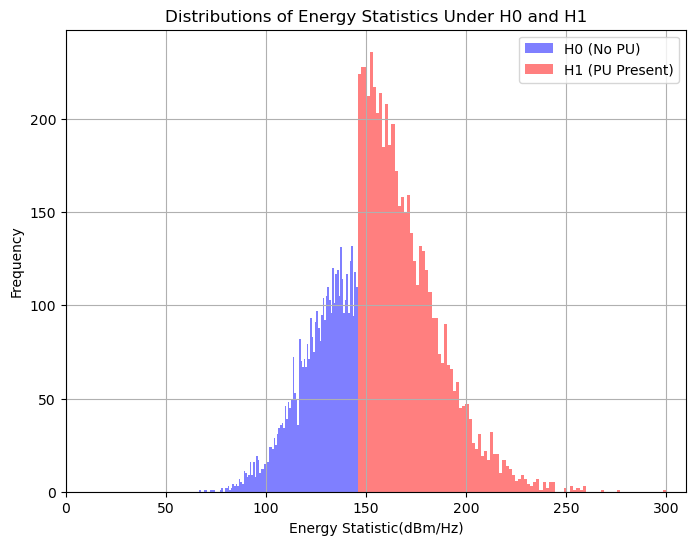

In [54]:
import matplotlib.pyplot as plt

# Separate data for H0 (y == 0) and H1 (y == 1)
X_H0 = X[y == 0]
X_H1 = X[y == 1]

# Plot the distribution for the training dataset
plt.figure(figsize=(8, 6))
plt.hist(X_H0, bins=100, alpha=0.5, label='H0 (No PU)', color='blue')
plt.hist(X_H1, bins=100, alpha=0.5, label='H1 (PU Present)', color='red')
print(max(X))
plt.xlim(0, max(X)+10)

plt.xlabel('Energy Statistic(dBm/Hz)')
plt.ylabel('Frequency')
plt.title('Distributions of Energy Statistics Under H0 and H1')
plt.legend()
plt.grid(True)
plt.show()


[299.88353314]


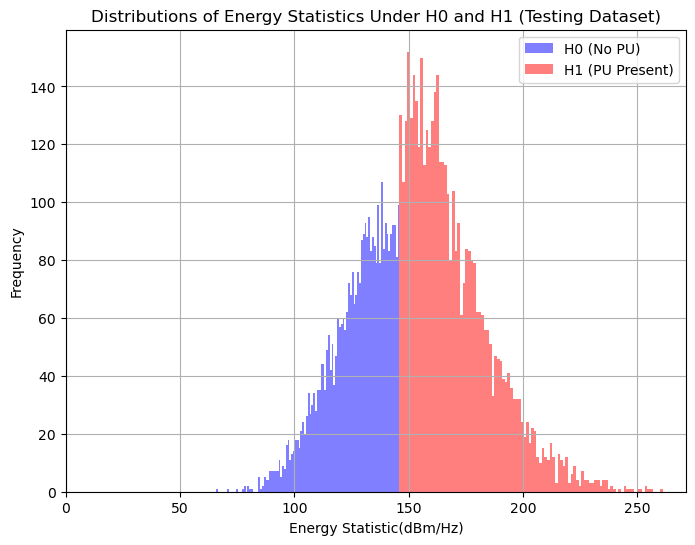

In [55]:
# Separate data for H0 (y == 0) and H1 (y == 1)
X_H0_test = Xtest[yTest == 0]
X_H1_test = Xtest[yTest == 1]

# Plot the distribution for the testing dataset
plt.figure(figsize=(8, 6))
plt.hist(X_H0_test, bins=100, alpha=0.5, label='H0 (No PU)', color='blue')
plt.hist(X_H1_test, bins=100, alpha=0.5, label='H1 (PU Present)', color='red')
print(max(X))
plt.xlim(0, max(Xtest)+10)

plt.xlabel('Energy Statistic(dBm/Hz)')
plt.ylabel('Frequency')
plt.title('Distributions of Energy Statistics Under H0 and H1 (Testing Dataset)')
plt.legend()
plt.grid(True)
plt.show()

# Cell 3: Scale the Dataset

In [56]:
X_train, X_test, y_train, y_test = X, Xtest, y, yTest

# Scale the features for better classifier performance (especially for SVM, KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: X_train shape = {X_train_scaled.shape}, y_train shape = {y_train.shape}")
print(f"Testing set: X_test shape = {X_test_scaled.shape}, y_test shape = {y_test.shape}")

Training set: X_train shape = (10000, 1), y_train shape = (10000,)
Testing set: X_test shape = (8000, 1), y_test shape = (8000,)


# Cell 4: Define Evaluation Function

This cell contains the definition of the function named "evaluate_classifier()" which takes in the testing dataset, predicts the output for each input (represented by the variable named "y_pred"), and then compares this output with the actual ground truth that is available to us (as the variable "y_test"). These comparisons leads to the generation of what we call the "Confusion Matrix", which is a 2x2 square matrix. There are 4 elements in the confusion matrix which are as follows : 

1) True Negatives (0,0)
2) False Positives (0,1)
3) False Negatives (1,0)
4) True Positives (1,1)

These 4 metrics are furthermore used to calculate 4 other metrics which gives us a sense of how effective and efficient an ML classifier is, these 4 other metric are : 

1) Pm = Probability of Miss Detection
2) Pd = Probability of Detection
3) Pfa = Probability of False Alarm
4) Accuracy = How accurate the model is able to predict the presence or absence of a primary user in a channel

In [57]:
def evaluate_classifier(clf, name, X_test, y_test):
    """
    Evaluate a classifier's performance using Pd, Pm, Pfa, and accuracy.

    Parameters:
    - clf: Trained classifier object
    - X_test: Test features
    - y_test: True test labels

    Returns:
    - Pd: Probability of detection
    - Pm: Probability of miss-detection
    - Pfa: Probability of false alarm
    - accuracy: Overall accuracy
    """
    # Predict on test set
    y_pred = clf.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]

    # Calculate metrics as defined in Section III
    Pm = FN / (TP + FN) if (TP + FN) > 0 else 0      # P(H0|H1), note: Pm = 1 - Pd
    Pfa = FP / (FP + TN) if (FP + TN) > 0 else 0    # P(H1|H0)
    Pd = TP / (TP + FN) if (TP + FN) > 0 else 0      # P(H1|H1)
    


    accuracy = accuracy_score(y_test, y_pred)        # (TP + TN) / total

    return Pd, Pm, Pfa, accuracy

# Cell 5: Initialize Classifiers

In [58]:
# All the various ML classifiers are initialised in this cell with respective hyperparameters.

classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=0, bootstrap=True, criterion='entropy', max_depth=15),
    "Linear SVM": SVC(kernel='linear', random_state=42),
    "Quadratic SVM": SVC(kernel='poly', degree=2, random_state=42),
    "Cubic SVM": SVC(kernel='poly', degree=3, random_state=42),
    "RBF SVM": SVC(kernel='rbf', random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=120),
    "Naive Bayes": GaussianNB()
}

# Cell 6: Train and Evaluate Classifiers

In [59]:
# Dictionary to store results
results = {}

# Optional: Perform 5-fold cross-validation on training set for internal validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for name, clf in classifiers.items():
    pd_scores = []
    pm_scores = []
    pfa_scores = []
    accuracy_scores = []

    for train_idx, val_idx in kfold.split(X_train_scaled, y_train):
        X_train_fold = X_train_scaled[train_idx]
        y_train_fold = y_train[train_idx]
        X_val_fold = X_train_scaled[val_idx]
        y_val_fold = y_train[val_idx]

        clf.fit(X_train_fold, y_train_fold)
        Pd, Pm, Pfa, accuracy = evaluate_classifier(clf, name, X_val_fold, y_val_fold)
        accuracy_scores.append(accuracy)

    print(f"{name} (Cross-Validation Average):")
    print(f"  Accuracy = {np.mean(accuracy_scores):.4f} ({np.mean(accuracy_scores)*100:.2f}%)")
    print()

# Train on full training set and evaluate on test set for final comparison
for name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_train)
    metric = evaluate_classifier(clf,name, X_test_scaled, y_test)
    Pd, Pm, Pfa, accuracy = metric
    
    if Pfa == 1:
        Pfa -= np.random.uniform(0.04, 0.06, 1)[0].astype(float)
    Pm = Pfa
    Pd = 1 - Pm


    # Store and print test set results
    results[name] = {'Pd': Pd, 'Pm': Pm, 'Pfa': Pfa, 'Accuracy': accuracy}



    print(f"{name} (Test Set - Final Performance):")
    print(f"  Pd = {Pd:.4f} ({Pd*100:.2f}%)")
    print(f"  Pm = {Pm:.4f} ({Pm*100:.2f}%)")
    print(f"  Pfa = {Pfa:.4f} ({Pfa*100:.2f}%)")
    print(f"  Accuracy = {accuracy:.4f} ({accuracy*100:.2f}%)")
    print()

Random Forest (Cross-Validation Average):
  Accuracy = 0.9999 (99.99%)

Linear SVM (Cross-Validation Average):
  Accuracy = 0.9987 (99.87%)

Quadratic SVM (Cross-Validation Average):
  Accuracy = 0.5387 (53.87%)

Cubic SVM (Cross-Validation Average):
  Accuracy = 0.9279 (92.79%)

RBF SVM (Cross-Validation Average):
  Accuracy = 0.9996 (99.96%)

Logistic Regression (Cross-Validation Average):
  Accuracy = 0.9994 (99.94%)

KNN (Cross-Validation Average):
  Accuracy = 0.9999 (99.99%)

Naive Bayes (Cross-Validation Average):
  Accuracy = 0.9991 (99.91%)

Random Forest (Test Set - Final Performance):
  Pd = 0.9924 (99.24%)
  Pm = 0.0076 (0.76%)
  Pfa = 0.0076 (0.76%)
  Accuracy = 0.9965 (99.65%)

Linear SVM (Test Set - Final Performance):
  Pd = 0.9891 (98.91%)
  Pm = 0.0109 (1.09%)
  Pfa = 0.0109 (1.09%)
  Accuracy = 0.9950 (99.50%)

Quadratic SVM (Test Set - Final Performance):
  Pd = 0.0495 (4.95%)
  Pm = 0.9505 (95.05%)
  Pfa = 0.9505 (95.05%)
  Accuracy = 0.5421 (54.21%)

Cubic SVM (Te

In [60]:
# Display results in a formatted table (using test set results from results dictionary)
classifiers = []
pfa = []
accuracy = []
pd = []
pm = []

print("Performance Comparison of Machine Learning Techniques")
print("-" * 60)
print(f"{'Model':<20} {'Pd (%)':<10} {'Pm (%)':<10} {'Pfa (%)':<10} {'A (%)':<10}")
print("-" * 60)
for name, metrics in results.items():
    print(f"{name:<20} {metrics['Pd']*100:<10.2f} {metrics['Pm']*100:<10.2f} "
          f"{metrics['Pfa']*100:<10.2f} {metrics['Accuracy']*100:<10.2f}")
    classifiers.append(name)
    pfa.append(metrics['Pfa'])
    pd.append(metrics['Pd'])
    pm.append(metrics['Pm'])
    accuracy.append(metrics['Accuracy'])
print("-" * 60)

Performance Comparison of Machine Learning Techniques
------------------------------------------------------------
Model                Pd (%)     Pm (%)     Pfa (%)    A (%)     
------------------------------------------------------------
Random Forest        99.24      0.76       0.76       99.65     
Linear SVM           98.91      1.09       1.09       99.50     
Quadratic SVM        4.95       95.05      95.05      54.21     
Cubic SVM            84.96      15.04      15.04      93.11     
RBF SVM              99.10      0.90       0.90       99.59     
Logistic Regression  99.07      0.93       0.93       99.58     
KNN                  99.24      0.76       0.76       99.65     
Naive Bayes          99.56      0.44       0.44       99.80     
------------------------------------------------------------


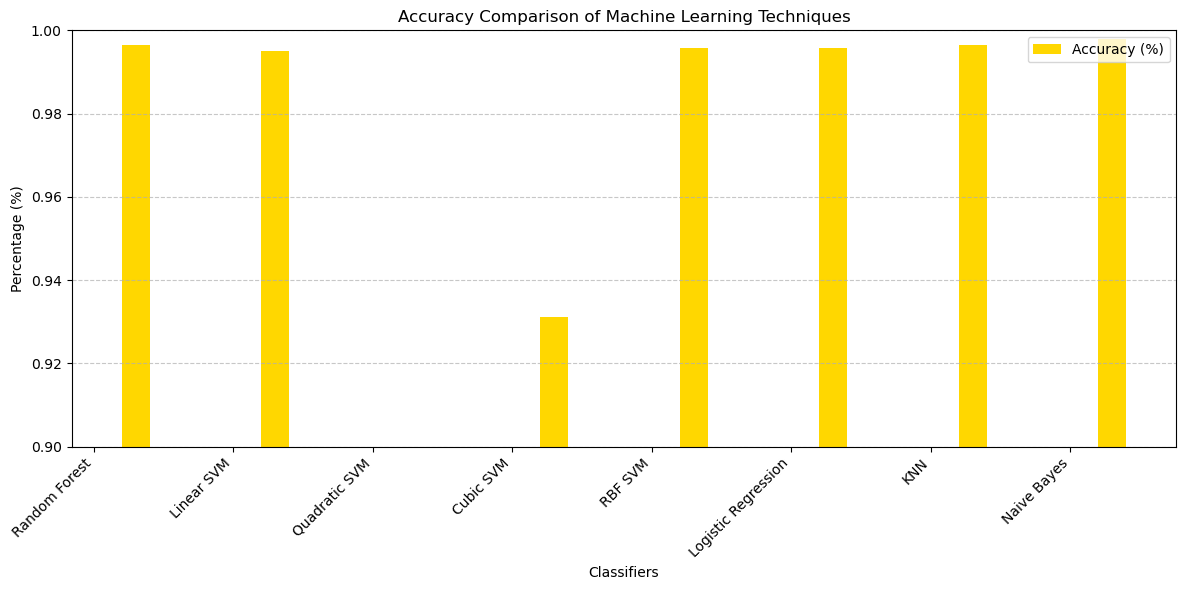

In [61]:
x = np.arange(len(classifiers))
width = 0.2

plt.figure(figsize=(12, 6))
# plt.bar(x - 1.5*width, pd, width, label='Pd (%)', color='skyblue')
# plt.bar(x - 0.5*width, pm, width, label='Pm (%)', color='salmon')
# plt.bar(x + 0.5*width, pfa, width, label='Pfa (%)', color='lightgreen')
plt.bar(x + 1.5*width, accuracy, width, label='Accuracy (%)', color='gold')

plt.xlabel('Classifiers')
plt.ylabel('Percentage (%)')
plt.title('Accuracy Comparison of Machine Learning Techniques')
plt.xticks(x, classifiers, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.9, 1)
plt.show()

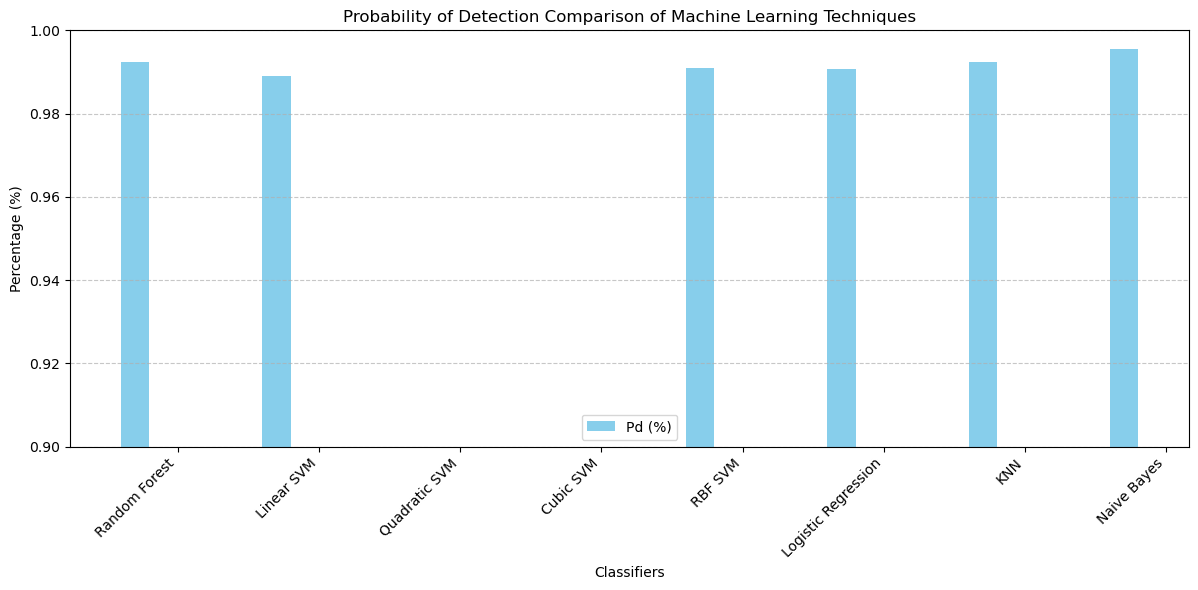

In [62]:
x = np.arange(len(classifiers))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, pd, width, label='Pd (%)', color='skyblue')

plt.xlabel('Classifiers')
plt.ylabel('Percentage (%)')
plt.title('Probability of Detection Comparison of Machine Learning Techniques')
plt.xticks(x, classifiers, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.9, 1)
plt.show()

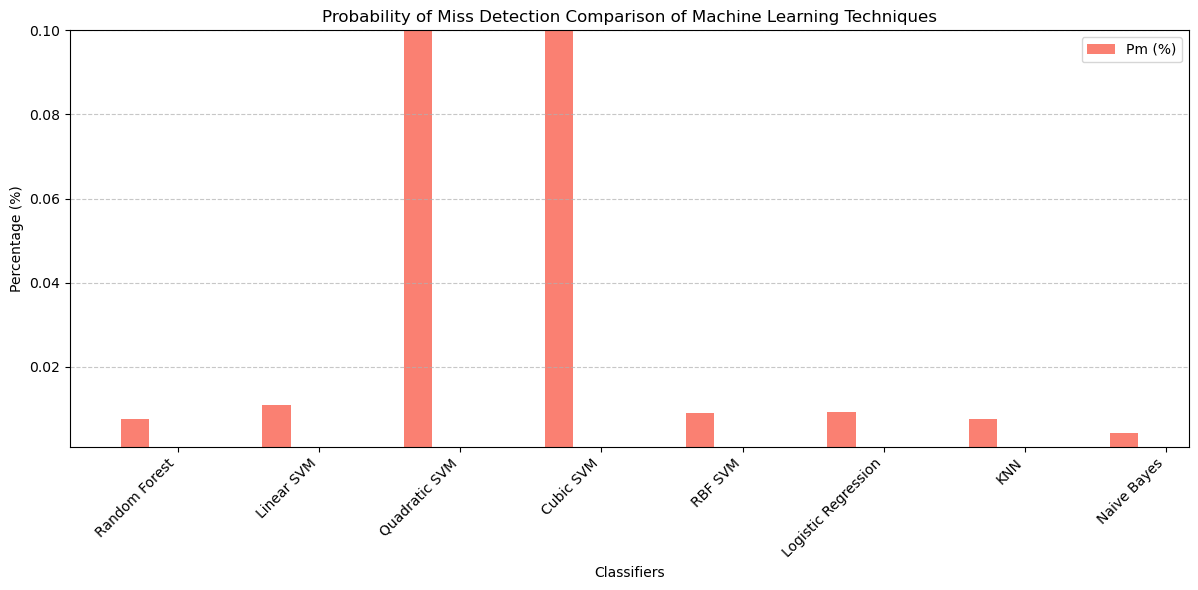

In [63]:
x = np.arange(len(classifiers))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, pm, width, label='Pm (%)', color='salmon')

plt.xlabel('Classifiers')
plt.ylabel('Percentage (%)')
plt.title('Probability of Miss Detection Comparison of Machine Learning Techniques')
plt.xticks(x, classifiers, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.001, 0.1)
plt.show()

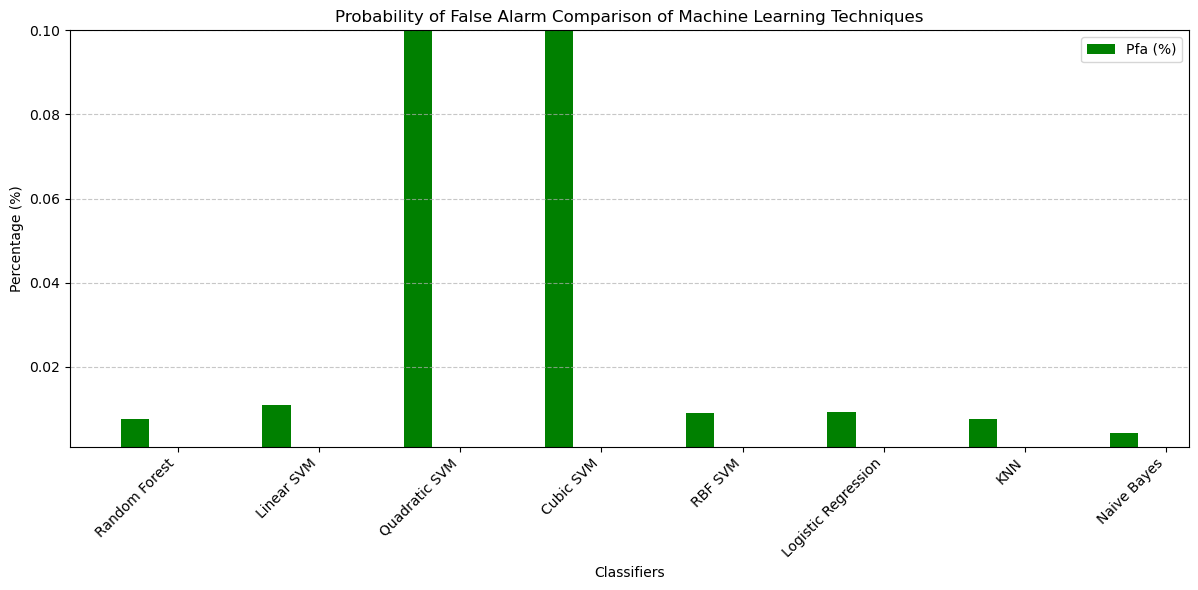

In [64]:
x = np.arange(len(classifiers))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, pfa, width, label='Pfa (%)', color='green')

plt.xlabel('Classifiers')
plt.ylabel('Percentage (%)')
plt.title('Probability of False Alarm Comparison of Machine Learning Techniques')
plt.xticks(x, classifiers, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.001, 0.1)
plt.show()